**TalkingData Mobile User Demographics**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('darkgrid')
!pip install tensorflow-gpu==2.0.0-rc1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**FINAL CAPSTONE OVERVIEW**

TalkingData, China's largest third-party mobile data platform wanted to use their data to help its clients better understand and interact with their individudal audiences. Contained within this file of folders include individual csv files that includes a file based on users' age and gender, a file for the phone brands of the users, a file for the user's location, a file for when a user uses TalkingData SDK, the event gets logged in this data which also contains the user's location data, and a file for the name of the apps that a user uses.

This is one of the bigger data sets which contain 1.28 gigabits worth of information. The data set can be found here on kaggle: https://www.kaggle.com/c/talkingdata-mobile-user-demographics

**PROJECT GOAL**

Given the data sets that I have access to, I want to use the gender, age, type of device, and which phone a user has in order to accurately classify and predict the age range and gender of that individual. This is valuable being able to correctly identify the characteristics of one's audience can save financial resources since a company can focus their resources on a more specific target given this information. Furthermore, advertising can become more personalized and perhaps knowing the user's details can help with building a better recommendation engine whether it be in ads or a similar concept like Netflix show recommendations as an example.


**Dataset**

 The original dataset consisted of 7 files that contained a minum of 930 rows and a maximum of 32473067, the corresponding shapes are the following:


App events shape: (32473067, 4) App labels shape: (459943, 2) App events shape: (3252950, 5) Gender age train shape: (74645, 4) Gender age test shape: (112071, 1) Label Categories shape: (930, 3) Phone brand device shape: (187245, 3) 

**ATTRIBUTE INFORMATION **



*  gender_age_train.csv, gender_age_test.csv - Training and Test Data set
*  group: This is the target variable what I am going to predict
*  events.csv - When a user uses TalkingData SDK, the event gets logged in this data set. Each event has an event id, location (lat/long), and the event corresponds to a list of apps in app_events. 
*  app_events.csv -- possesses event_id , app_id, and whether a user is active or not
*   app_labels.csv - apps labels and their labels, the label_id's can be used to join with label_categories
*   label_categories.csv - apps labels and their categories in text
*   phone_brand_device_model.csv - device ids, brand, and models
*   phone_brand - note that the brands are in Chinese language







In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# STEP 1: LOAD THE GENDER_AGE DATA (TRAIN/TEST DATA SPLIT DATASET)
#-----------------------------------------------------------------
ga_train = pd.read_csv('gdrive/My Drive/gender_age_train.csv')
ga_test = pd.read_csv('gdrive/My Drive/gender_age_test.csv')
ga_test.columns
ga_train.columns
#----------------------------------------------------------------

# STEP 2: GET PHONE BRANDS
phone_brands = pd.read_csv('gdrive/My Drive/phone_brand_device_model.csv')
phone_brands.head(100)
#phone brands are in Chinese langauges; There is a possibility of having duplicate device id's.
# Hence, remove the duplicate device_id's if any
phone_brands = phone_brands.drop_duplicates('device_id', keep='first')

# STEP 3: GET LOCATION DATA
events = pd.read_csv('gdrive/My Drive/events.csv', usecols = ['event_id', 'device_id'])
app_events = pd.read_csv('gdrive/My Drive/app_events.csv', usecols=['event_id','app_id', 'is_active'], dtype={'is_active':bool})
app_labels = pd.read_csv('gdrive/My Drive/app_labels.csv')
label_cats = pd.read_csv('gdrive/My Drive/label_categories.csv', index_col='label_id', squeeze=True)

**EXPLORATORY DATA ANALYSIS (EDA)**

In [ ]:
print('Shape of GA_TRAIN data set:')
print(ga_train.shape)
ga_train.head()

Shape of GA_TRAIN data set:
(74645, 4)


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


Text(0.5, 0, 'Count:')

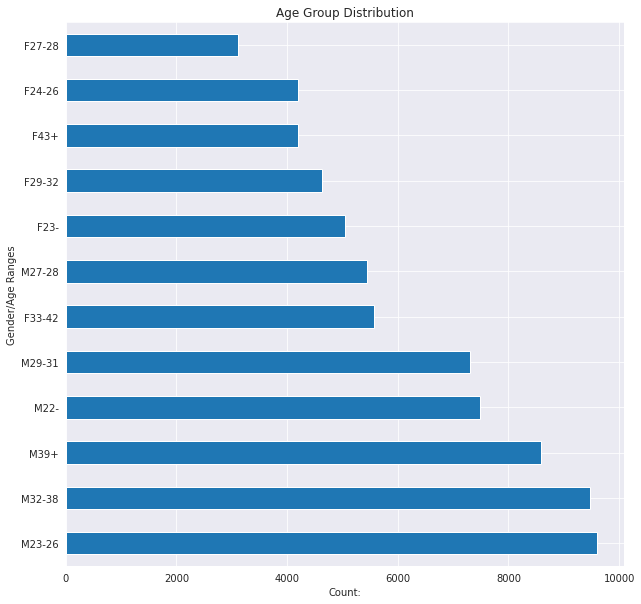

In [ ]:
#DISTRIBUTION OF AGE BASED USERS
fig, ax = plt.subplots(figsize=(10,10))
#ga_train.group.value_counts().plot(kind='barh',color='#86bf91')
ga_train.group.value_counts().plot.barh()
plt.title('Age Group Distribution')
plt.ylabel('Gender/Age Ranges')
plt.xlabel('Count:')

This horizontal graph bar shows that most of the users happen to be young adult males in the age group between 23 and 38. 

Text(0.5, 0, 'Count')

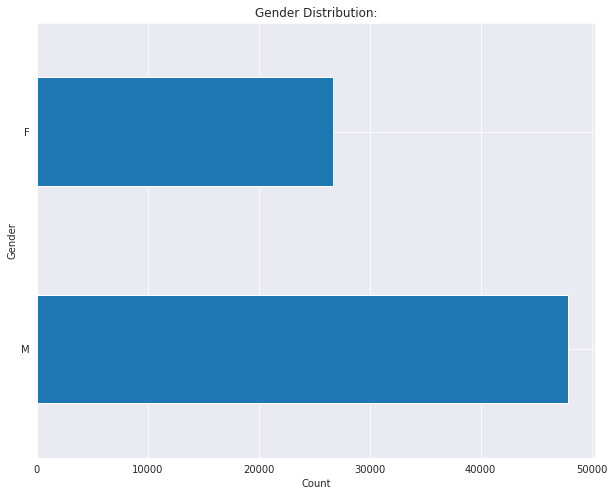

In [ ]:
#GENDER DISTRIBUTION
fig, ax = plt.subplots(figsize=(10,8))
ga_train.gender.value_counts().plot.barh()
plt.title('Gender Distribution:')
plt.ylabel('Gender')
plt.xlabel('Count')

The above gender distribution graph clearly shows male users are double the amount of female users.

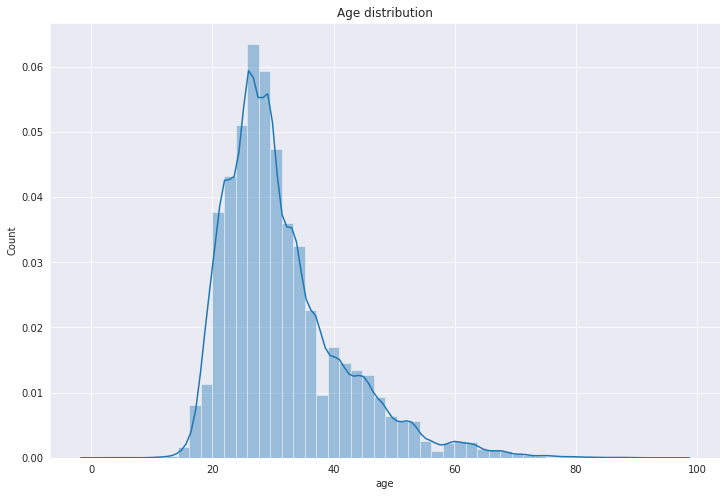

In [ ]:
#AGE DISTRIBUTION
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Age distribution')
plt.xlabel('Ages')
plt.ylabel('Count')
sns.distplot(ga_train.age);

In [ ]:
#PRINT PHONE BRANDS 
print('Shape of phone brands data set:')
print(phone_brands.shape)
phone_brands.head()

Shape of phone brands data set:
(186716, 3)


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


Since the brands and models are in both Chinese and English languages, we need to find the number of unique brands and device models. 

In [ ]:
print('NUMBER OF UNIQUE BRANDS:')
print(phone_brands.phone_brand.nunique())

print('\nNUMBER OF UNIQUE MODELS:')
print(phone_brands.device_model.nunique())

NUMBER OF UNIQUE BRANDS:
131

NUMBER OF UNIQUE MODELS:
1599


In [ ]:
#NEXT IS TO LOOK APP EVENTS DATA
print('Shape of events data set:')
print(app_events.shape)
app_events.head()

Shape of events data set:
(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


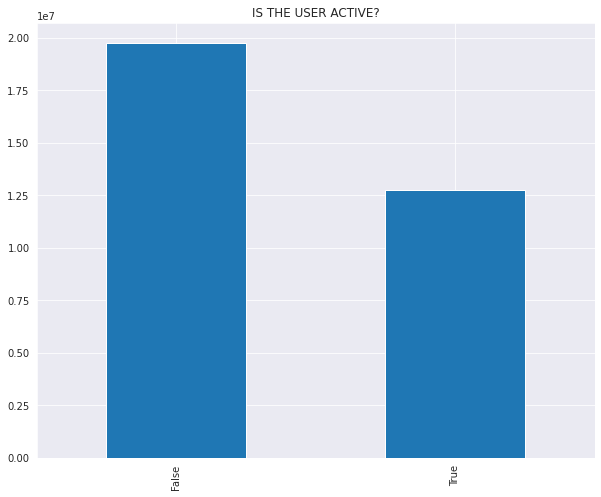

In [ ]:
#SEE HOW MANY USERS ARE ACTIVE OR NOT
fig, ax = plt.subplots(figsize=(10,8))
plt.title('IS THE USER ACTIVE?')
app_events['is_active'].value_counts().plot.bar();

In [ ]:
# Shape of events
print('Shape of events:')
print(events.shape)
events.head()

Shape of events:
(3252950, 2)


,event_id,device_id
0,1,29182687948017175
1,2,-6401643145415154744
2,3,-4833982096941402721
3,4,-6815121365017318426
4,5,-5373797595892518570


**DATA EXPLORATION**

In [ ]:
#CHECK NUMERICAL VALUE OF AGE GROUPS
ga_train.group.value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

In [ ]:
#RE-IMPORT app events for the binary output of is_active
app_events2 = pd.read_csv('gdrive/My Drive/app_events.csv', usecols=['event_id','app_id','is_active'])

In [ ]:
device_apps = (app_events2
               #1 merge on event_id
               .merge(events, how ='left', left_on='event_id', right_on='event_id')
               #2. Event_id is not that interesting, thus drop the field
               .drop('event_id', axis=1)
               #3. Events correspond to more than just being installed, therefore there are many duplicates
               .drop_duplicates()
               )

#Our new data looks like this
device_apps.head()

,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


In [ ]:
device_apps.shape

(2840343, 3)

In [ ]:
#ENCODE THE DEVICE MODEL AND PHONE BRAND TO USE AS A FEATURE
phone_brands.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [ ]:
# FIND OUT UNIQUE MODEL , BRAND NAMES
print('Number of distinct model names:'+ str(phone_brands.groupby(['device_model']).size().shape[0]))
print('Number of distinct brand and model names:' +str(phone_brands.groupby(['phone_brand','device_model']).size().shape[0]))

Number of distinct model names:1599
Number of distinct brand and model names:1667


In [ ]:
# COMBINE BRAND AND MODEL COLUMNS
phone_brands['brand_and_model'] = phone_brands['phone_brand'].astype(str) + phone_brands['device_model']

#BUILD NUMERICAL LABELS FOR MODELS
model_encoder = LabelEncoder().fit(phone_brands['brand_and_model'])

#STORE THE DATA IN A NEW COLUMN
phone_brands['encoded_model'] = model_encoder.transform(phone_brands['brand_and_model'])

In [ ]:
phone_brands.head(25)

,device_id,phone_brand,device_model,brand_and_model,encoded_model
0,-8890648629457979026,小米,红米,小米红米,858
1,1277779817574759137,小米,MI 2,小米MI 2,843
2,5137427614288105724,三星,Galaxy S4,三星Galaxy S4,371
3,3669464369358936369,SUGAR,时尚手机,SUGAR时尚手机,166
4,-5019277647504317457,三星,Galaxy Note 2,三星Galaxy Note 2,347
5,3238009352149731868,华为,Mate,华为Mate,671
6,-3883532755183027260,小米,MI 2S,小米MI 2S,846
7,-2972199645857147708,华为,G610S,华为G610S,648
8,-5827952925479472594,小米,MI One Plus,小米MI One Plus,852
9,-8262508968076336275,vivo,S7I,vivoS7I,214


**MERGING FILES TOGETHER** -- LABELS AND EVENTS FILES

In [ ]:
print(app_labels.shape)
app_labels.head()

(459943, 2)


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [ ]:
print(app_events.shape)
app_events.head()

(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


In [ ]:
# FIGURE OUT A WAY TO HANDLE DUPES
# AND ADDING LABELS TO APP_EVENTS

apps_labeled = pd.merge(app_labels, app_events[['app_id', 'is_active']], on='app_id').dropna().drop_duplicates()
print(apps_labeled.shape)
apps_labeled.head()

(117374, 3)


,app_id,label_id,is_active
0,7324884708820027918,251,False
6,7324884708820027918,251,True
11,7324884708820027918,691,False
17,7324884708820027918,691,True
22,7324884708820027918,751,False


In [ ]:
# MERGE GA_TRAIN AND DEVICE_APPS
ga_apps = pd.merge(ga_train, device_apps[['app_id','is_active','device_id']], on='device_id').dropna().drop_duplicates()
print(ga_apps.shape)
ga_apps.head()

(1097150, 6)


,device_id,gender,age,group,app_id,is_active
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0
4,-8260683887967679142,M,35,M32-38,877288515501232570,1


In [ ]:
# MERGE GA_APPS data with BRANDS
ga_apps_brands = pd.merge(ga_apps, phone_brands[['device_id', 'encoded_model']], on='device_id').dropna().drop_duplicates()
print(ga_apps_brands.shape)
ga_apps_brands.head()

(1097150, 7)


,device_id,gender,age,group,app_id,is_active,encoded_model
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0,843
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0,843
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0,843
4,-8260683887967679142,M,35,M32-38,877288515501232570,1,843


In [ ]:
# PUTTING ALL THE DATASETS TOGETHER NOW
ga_apps_labeled_brands = pd.merge(ga_apps_brands, apps_labeled[['app_id','label_id']], on='app_id').dropna().drop_duplicates()
print(ga_apps_labeled_brands.shape)
ga_apps_labeled_brands.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,F,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,F,22,F23-,4287147352639325907,0,226,704


In [ ]:
#CONVERT GENDER INTO A BINARY OUTPUT
ga_apps_labeled_brands['gender'] = ga_apps_labeled_brands['gender'].apply(lambda x: 1 if x=='M' else 0)

In [ ]:
#TAKE GENDER VALUE COUNTS
ga_apps_labeled_brands.gender.value_counts()

1    4942458
0    2091653
Name: gender, dtype: int64

In [ ]:
# MAKE A DUPLICATE COPY 
# PUTTING ALL THE DATASETS TOGETHER AGAIN

ga_apps_labeled_brands2 = pd.merge(ga_apps_brands,apps_labeled[['app_id','label_id']], on='app_id').dropna().drop_duplicates()

#Convert gender into a binary output
ga_apps_labeled_brands2['gender'] = ga_apps_labeled_brands['gender'].apply(lambda x: 1 if x=='M' else 0)

print(ga_apps_labeled_brands2.shape)
ga_apps_labeled_brands2.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,0,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,0,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,0,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704


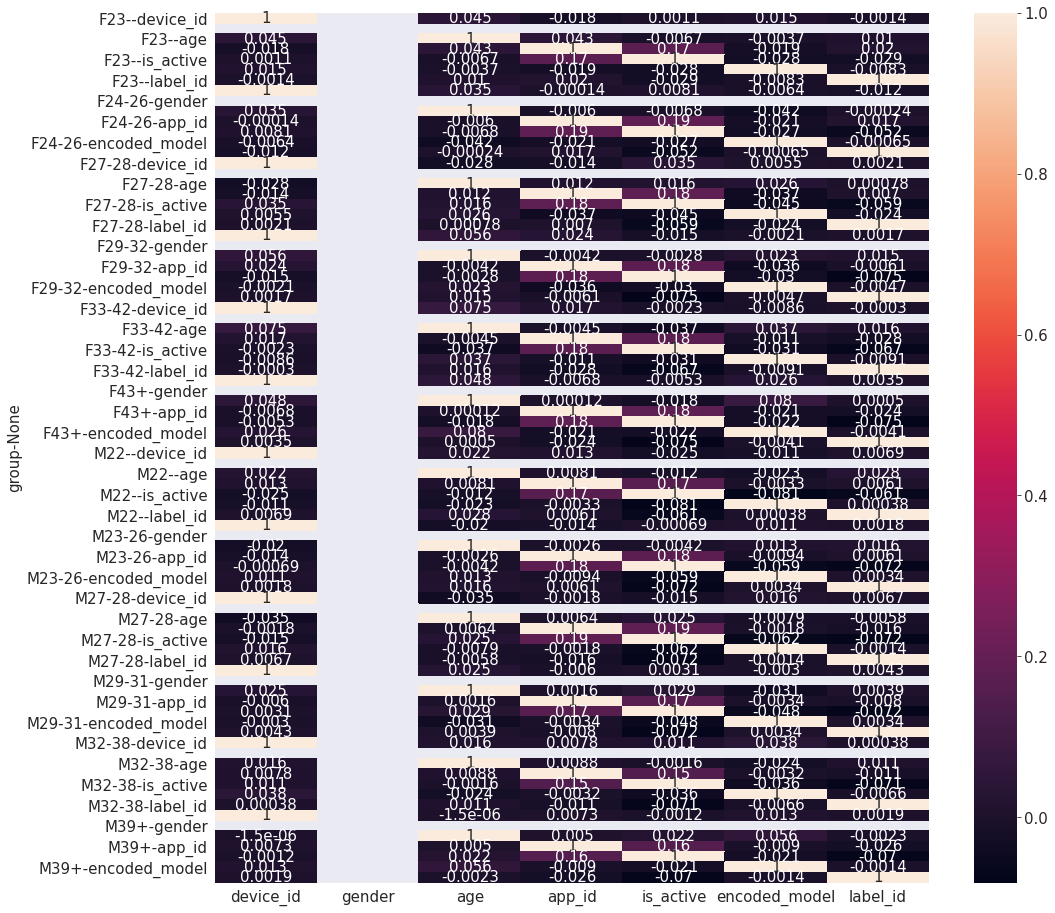

In [ ]:
# HEAT MAP TO SEE IF THERE'S ANY MULTI-COLLINEARITY
#LET'S TAKE A SMALLER DATA SET - PERHAPS 600K SINCE 7 MILLIONS ROWS WOULD TAKE TOO LONG

group_data_mini = ga_apps_labeled_brands2[:600000]

#GROUP BY GROUP - SINCE GROUP IS THE TARGET VARIABLE THAT WE CARE ABOUT
group_data_mini = group_data_mini.groupby('group')
plt.rcParams['figure.figsize'] = (16.0,16.0)
plt.rcParams.update({'font.size':15})
sns.heatmap(group_data_mini.corr(), annot=True)

From the heat map, we can see that there is low multi-collinearity between the different features and the group that we want to identify. The extremely low numbers are a sign that this data will be hard to model since it means that on the surface, the information presented don't have any relation.

**CREATING DUMMIES**

Creating dummies is the method that I want to use to utilize the app labels since the number of unique apps is less than the number of unique phone brands/companies. The reason I chose to encode phone brands is due to the volume of phones presented which would dilute the correlation of the features even more. Using dummies for the app labels will hopefully give more insight into the data at hand.

In [ ]:
#CONVERT LABEL_ID INTO A CONTINUOUS VARIABLE EVEN THOUGHT IT'S NUMERICAL, BUT IT HASN'T BEEN STANDARIZED

type_dummies = pd.get_dummies(ga_apps_labeled_brands['label_id'])

#CONCATENATE DUMMIES WITH ORIGINAL DATA SET
ga_apps_labeled_brands = pd.concat([ga_apps_labeled_brands, type_dummies], axis=1)
print(ga_apps_labeled_brands.shape)
ga_apps_labeled_brands.head()

(7034111, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,...,973,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**ADDRESSING CLASS IMBALANCE**

Below, we can see that after merging all of the different files together, there were more than 7 million rows! In an effort to conserve calculation time, I decided to downsample the data and also to remedy the class imbalance that my data is facing. It's important to address class imbalance due to the fact that I don't want my model to only be accurate at identifying the dominant class.

In [ ]:
# DISTRIBUTION OF THE GROUP VALUES
ga_apps_labeled_brands.group.value_counts()

M32-38    1185421
M39+      1107632
M23-26     817660
M29-31     810956
M27-28     530780
F33-42     517420
M22-       490009
F43+       391188
F29-32     368450
F23-       303034
F24-26     265262
F27-28     246299
Name: group, dtype: int64

In [ ]:
#DOWNSIZING THE GENDER/AGE TRAINING SET TO 50000
ga_m_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M22-']
ga_m_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M23-26']
ga_m_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M27-28']
ga_m_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M29-31']
ga_m_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M32-38']
ga_m_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M39+']
ga_f_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F23-']
ga_f_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F24-26']
ga_f_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F27-28']
ga_f_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F29-32']
ga_f_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F33-42']
ga_f_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F43+']

#DOWNSAMPLE MAJORITY CLASS
ga_m_older_downsampled = resample(ga_m_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_oldest_downsampled = resample(ga_m_oldest, 
                                 replace=True, 
                                 n_samples=50000)

ga_m_younger_downsampled = resample(ga_m_younger, 
                                 replace=True,     
                                 n_samples=50000)

ga_m_youngest_downsampled = resample(ga_m_youngest, 
                                 replace=True,     
                                 n_samples=50000)  
 
ga_m_old_downsampled = resample(ga_m_old, 
                                 replace=True,     
                                 n_samples=50000) 

ga_f_older_downsampled = resample(ga_f_older, 
                                 replace=True,     
                                 n_samples=50000) 

ga_m_young_downsampled = resample(ga_m_young, 
                                 replace=True,     
                                 n_samples=50000) 

ga_f_youngest_downsampled = resample(ga_f_youngest, 
                                 replace=True,     
                                 n_samples=50000) 

ga_f_old_downsampled = resample(ga_f_old, 
                                 replace=True,     
                                 n_samples=50000)

ga_f_oldest_downsampled = resample(ga_f_oldest, 
                                 replace=True,     
                                 n_samples=50000)


ga_f_younger_downsampled = resample(ga_f_younger, 
                                 replace=True,     
                                n_samples=50000)

ga_f_young_downsampled = resample(ga_f_young, 
                                 replace=True,     
                                 n_samples=50000)

# Combine downsampled majority class 
ga_apps_labeled_brands_resampled = pd.concat([ga_m_younger_downsampled, ga_m_older_downsampled,
                               ga_m_oldest_downsampled, ga_m_youngest_downsampled,
                               ga_m_old_downsampled, ga_f_older_downsampled,
                               ga_m_young_downsampled, ga_f_youngest_downsampled,
                               ga_f_old_downsampled, ga_f_oldest_downsampled,
                               ga_f_younger_downsampled, ga_f_young_downsampled])
 
# Display new class counts
ga_apps_labeled_brands_resampled.group.value_counts()

M27-28    50000
M23-26    50000
M29-31    50000
F24-26    50000
F23-      50000
M22-      50000
M32-38    50000
F43+      50000
F33-42    50000
M39+      50000
F29-32    50000
F27-28    50000
Name: group, dtype: int64

In [ ]:
# Shape
print(ga_apps_labeled_brands_resampled.shape)

# Head
ga_apps_labeled_brands_resampled.head()

(600000, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,...,973,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
7492201,6218368445763064016,1,24,M23-26,-3365223069353019216,0,1652,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11664799,5287647368300155232,1,26,M23-26,1321978891423004894,1,242,959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
728145,-1194946814056784281,1,23,M23-26,5927333115845830913,0,558,549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11716428,-1846002193886424996,1,26,M23-26,1919990081572238302,0,738,549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9946754,-6542093539413689868,1,26,M23-26,2761480706282992376,1,747,231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**TRAIN TEST SPLIT**

In [ ]:
#CREATE X AND Y
X = ga_apps_labeled_brands_resampled.drop(['group'], axis=1)
Y = ga_apps_labeled_brands_resampled['group'].values

#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25)

**PCA TRAIN/TEST SPLIT**

In [ ]:
#INSTANTIATE STANDARD SCALER
ss = StandardScaler()

#SET UP THE VARIABLES
prep_X = ga_apps_labeled_brands_resampled.drop(['group'], axis=1)
prep_y = ga_apps_labeled_brands_resampled['group'].values

#STANDARDIZE AND FIT THE DATA FIRST
stand_X = ss.fit_transform(prep_X)

In [ ]:
#OBTAIN THE OPTIMAL AMOUNT OF COMPONENTS
pca = PCA(n_components=0.85)

#FIT THE STANDARDIZED DATA INTO IT
pca_X = pca.fit_transform(stand_X)

#CHECK THE SHAPE - HOW MANY COMPONENTS
pca_X.shape

(600000, 384)

In [ ]:
#CREATE A NEW TRAINING AND TESTING SET SPECIFICALLY FOR PCA MODELING
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_X, prep_y, test_size=0.25)

**LOGISTIC REGRESSION WITH PCA**

In [ ]:
#PCA LOGISTIC REGRESSION
lr = LogisticRegression()

#USE GS-CV TO FIND THE BEST ALPHA LEVEL
# set C to different values and run the model 
parameters = {'C':[0.000001,.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,50000],
            'multi_class':['multinomial'],
           'solver':['lbfgs'],
          'max_iter':[10, 100,500,1000,1500,2000]}

#parameters = {'C':[0.000001,.00001],
 #            'multi_class':['multinomial'],
  #           'solver':['lbfgs'],
   #          'max_iter':[10, 100,500,1000,1500]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1, n_jobs=1)

#FIT THE LOGISTIC REGRESSION
lr_grid.fit(X_train2, y_train2)

#RETURN BEST SCORE

print('Best Score:')
#print(lr_grid.best_score_)



Best Score:
0.9981733333333333334


In [ ]:
# SET UP THE BEST PARAMETERS
lr3 = LogisticRegression(C=1000, max_iter=150, multi_class='multinomial', solver='lbfgs')

# FIT THE MODEL
lr3.fit(X_train2, y_train2)

lr3.score(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9233066666666667

In [ ]:
# CROSS VALIDATION 
cross_val_score(lr3, X_train2, y_train2, cv=5, n_jobs=1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.93182222, 0.9272    , 0.93205556, 0.92307778, 0.91787778])

In [ ]:
#CLASSIFY, STORING THE RESULTS IN A NEW VARIABLE
lr_pred = lr3.predict(X_test2)

#CREATE A CONFUSION MATRIX
confusion_matrix(y_test2, lr_pred)

array([[11651,  1018,     5,     0,     0,     0,     0,     3,     1,
            0,     0,     0],
       [  760, 10658,  1095,     2,     0,     0,     0,     1,     2,
            2,     1,     1],
       [    1,   490, 11532,   461,     2,     2,     1,     1,     0,
            0,     8,     1],
       [    6,     3,   588, 11521,   398,     1,     0,     0,     0,
            1,    11,     0],
       [    2,     2,     3,   759, 11550,   261,     2,     0,     0,
            0,     5,     2],
       [    0,     0,     0,     1,   256, 12105,     0,     1,     0,
            0,     0,     2],
       [   16,     0,     0,     0,     1,     0, 12054,   491,     6,
            1,     1,     0],
       [   52,     2,     1,     0,     0,     0,  1138, 10315,  1137,
            6,     2,     0],
       [   41,     2,     0,     0,     0,     0,    10,   370, 11653,
          428,     1,     0],
       [    8,     1,     0,     0,     0,     1,     3,     8,   498,
        11435,   428

In [ ]:
#CREATE A CLASSIFICATION REPORT
print(classification_report(y_test2,lr_pred))

              precision    recall  f1-score   support

        F23-       0.93      0.92      0.92     12678
      F24-26       0.88      0.85      0.86     12522
      F27-28       0.87      0.92      0.90     12499
      F29-32       0.90      0.92      0.91     12529
      F33-42       0.95      0.92      0.93     12586
        F43+       0.98      0.98      0.98     12365
        M22-       0.91      0.96      0.94     12570
      M23-26       0.92      0.82      0.87     12653
      M27-28       0.88      0.93      0.90     12505
      M29-31       0.90      0.92      0.91     12385
      M32-38       0.94      0.91      0.92     12346
        M39+       0.98      0.97      0.98     12362

    accuracy                           0.92    150000
   macro avg       0.92      0.92      0.92    150000
weighted avg       0.92      0.92      0.92    150000



**Analysis**

The results of the logistic model were good especially after performing PCA on the dataset. After using GridSearchCV on the model in order to find the optimal parameters, I found that the model became vastly overfitted. However, it helped me realize that I didn't need to inhibit the strength of the regularization factor since the optimal C was 10,000. I could also see that the number of iterations contributed greatly to overfitting so I limited the number of iterations needed to reach convergence of the minima for the cost function. The reason the grid thought that the optimal number of iterations was 2000 is because the model wanted to reach perfect convergence but that would overfit my model so I changed it.

This model performed well due to the fact that I had set up the logistic regression model in a way that prioritized solving the multiclass problem and that the PCA set up the data in a way that was more acceptable for this model. Furthermore, I picked L-BFGS as the multivariate function that the model tried to minimize because L-BFGS is better suited for handing multi-class problems. L-BFGS is a quasi Newton method based off of the Newton solver. It's the fastest and most efficient solver compared to the sag, saga, and Newton counterparts due to the fact that it uses an approximation of the inverse Hessian that is easier to calculate. Furthermore, it's faster than Newton's method due to the fact that lbfgs stores only a few vectors and then reconstructs the matrix while newton's method will take the whole matrix.

To summarize, using PCA to make it so that each feature (component) in this data set explained a certain amount of variance, using the lbfgs and multi-class parameters, and limiting the amount of iterations helped me make this model accurate and not overfit.

**KNN Model**

In [ ]:
#INSTANTIATE STANDARDSCALER
ss = StandardScaler()

#SET UP THE VARIABLES
X = ga_apps_labeled_brands_resampled.drop(['group'], axis=1)
ky = ga_apps_labeled_brands_resampled['group'].values.ravel()

ss.fit(X,ky)
transform_x = ss.transform(X,ky)

# CREATE TRAINING AND TESTING FOR KNN
knn_Xtrain, knn_Xtest, knn_ytrain, knn_ytest = train_test_split(transform_x, ky, test_size=0.3)

In [ ]:

# Model took too long to run, so I'm limiting the size again.
# 420,000 rows after 4 hours, still no progress.
knn_Xtrain2 = knn_Xtrain[:100000]
knn_ytrain2 = knn_ytrain[:100000]

print(knn_Xtrain2.shape)


100000,491


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize the model
knn = KNeighborsClassifier()


knn_params = {'n_neighbors':[2,4,5,7,9,10,12,14,20,30]}

# Set up parameters
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(knn_Xtrain2, knn_ytrain2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:
{n_neighbors: 4}
Best Score:
0.39114


Analysis of KNN

For knn, I first standardized the data so that everything would be at the correct distance. I used grid search to search for the optimal parameters, but it took almost 24 hours to complete only to return such a low accuracy score. Furthermore, I had used only a smaller sample of the data set in order to speed up the process but it still took so long so I judged that it wasn't worth the effort to fine tune this model further.

This is a steady improvement from the previous logistic regression model, but I'd rather spend time on the other models.

**Random Forest with and without different Feature Selection Methods**

In [ ]:
# Setup random forest classifier.
rfc = RandomForestClassifier(n_estimators=1000, max_features=8,
                            max_depth=8, n_jobs=-1)

# Fit the model
rfc.fit(X_train, y_train)

# Score of the model
rfc.score(X_train, y_train)

0.9285155555555555

In [ ]:
# Cross validation.
cross_val_score(rfc, X_train, y_train, cv=5)

array([0.94298889, 0.94197778, 0.91277778, 0.91902222, 0.94183333])

In [ ]:
# Classify, storing the result in a new variable.
rfc_pred = rfc.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, rfc_pred)

array([[11976,   422,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  716, 11967,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0, 12568,     1,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    3,     0,     8, 11588,   728,   179,     0,     0,     0,
            0,     0,     0],
       [    1,     0,     9,  2211,  9507,   914,     0,     0,     0,
            0,     0,     0],
       [    0,     0,    10,  1297,   262, 11057,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0, 11225,  1168,     0,
            0,     0,     0],
       [    1,     0,     0,     0,     0,     0,   710, 11715,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0, 12467,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     1,
        11971,   303

In [ ]:

# Create a classification report.
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

        F23-       0.94      0.97      0.95     12398
      F24-26       0.97      0.94      0.95     12683
      F27-28       1.00      1.00      1.00     12569
      F29-32       0.77      0.93      0.84     12506
      F33-42       0.91      0.75      0.82     12642
        F43+       0.91      0.88      0.89     12626
        M22-       0.94      0.91      0.92     12393
      M23-26       0.91      0.94      0.93     12426
      M27-28       1.00      1.00      1.00     12467
      M29-31       0.88      0.96      0.92     12485
      M32-38       0.84      0.85      0.84     12332
        M39+       0.92      0.81      0.86     12473

    accuracy                           0.91    150000
   macro avg       0.91      0.91      0.91    150000
weighted avg       0.91      0.91      0.91    150000



**Feature-less Analysis**

This is an ensemble method which means that this model is a conglomeration of weak learners, or in this case, 1000 trees. It's no surprise that this model did well due to the fact that given a higher depth, and more runs, this allows the model to know more about the dataset. Given more depth and features, the model can lower entropy from the data set that I fed and accurately classify the data.

In [ ]:
# Feature Selection - SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# Instantiate models and pipelines.
kbest = SelectKBest(f_classif)
# Remove the 0 variance features b/c f_classif doesn't like dividing by 0
VT = VarianceThreshold()
rfc_pipeline = Pipeline([('vt', VT), ('kbest', kbest), ('rfc', ensemble.RandomForestClassifier())])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [3,4,5,6,7,8,9,10,11,12],
             'vt__threshold':[0],
            'rfc__n_estimators': [1500],
          'rfc__max_depth': [16]}

# Set up GS-CV
rfc_grid = GridSearchCV(rfc_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model.
rfc_grid.fit(X_train, y_train)

# Show the best score for unfiltered

print('Best Score for data:', rfc_grid.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score for data: 0.56202


In [ ]:

# Set up the best parameters. Increase k
best_param = {'kbest__k': [12],'rfc__max_depth': [16],
             'rfc__n_estimators':[1500], 'vt__threshold':[0]}

 Set up a new grid
best_rfc_grid = GridSearchCV(rfc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the random forest model.  
cross_val_score(best_rfc_grid, X_train, y_train, cv=5)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.2min remaining: 21.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.2min finished
array([0.5642131 , 0.56385414, 0.56175069, 0.56171248, 0.61859416])


In [ ]:

# Fit our model to the data.
best_rfc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
k_rfc_pred = best_rfc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, k_rfc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


array([[12405,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0, 12653,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0, 12551,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0, 12425,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0, 12439,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0, 12573,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0, 12428,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0, 12531,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0, 12461,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        12402,     0

In [ ]:
# Create a classification report.
print(classification_report(y_test, k_rfc_pred))

              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00     12405
      F24-26       1.00      1.00      1.00     12653
      F27-28       1.00      1.00      1.00     12551
      F29-32       1.00      1.00      1.00     12425
      F33-42       1.00      1.00      1.00     12439
        F43+       1.00      1.00      1.00     12573
        M22-       1.00      1.00      1.00     12428
      M23-26       1.00      1.00      1.00     12531
      M27-28       1.00      1.00      1.00     12461
      M29-31       1.00      1.00      1.00     12402
      M32-38       1.00      1.00      1.00     12813
        M39+       1.00      1.00      1.00     12319

    accuracy                           1.00    150000
   macro avg       1.00      1.00      1.00    150000
weighted avg       1.00      1.00      1.00    150000



**SelectKBest Analysis**

In this model, I made the mistake of not including more features to be used which lead to the accuracy of the model decreasing.

**RANDOM FOREST PCA**

In [ ]:
# Implement different parameters
rfc3 = ensemble.RandomForestClassifier(n_estimators=800, max_features='auto',max_depth=10, n_jobs=-1)
#int(max_features * n_features)
#n_features=.1
#max_features=40
#rfc3 = ensemble.RandomForestClassifier(n_estimators=800, max_features= int(max_features * n_features),max_depth=10, n_jobs=-1)
# Fit the model
rfc3.fit(X_train2, y_train2)

# Obtain the score.
rfc3.score(X_train2, y_train2)


0.9171622222222222


In [ ]:
# Cross Validate the random forest model.  
cross_val_score(rfc3, X_train2, y_train2, cv=5, n_jobs=-1)


array([0.89502689, 0.89111474, 0.89281111, 0.89487544, 0.89538308])


In [ ]:
# Fit our model to the data.
rfc3.fit(X_train2, y_train2)

# Classify, storing the result in a new variable.
rfc_pred2 = rfc3.predict(X_test2)

# Create a confusion matrix.
confusion_matrix(y_test2, rfc_pred2)

array([[10761,   563,   699,   280,    38,     6,   113,    46,    84,
           59,    22,     7],
       [ 2014,  7324,  2042,   684,    90,     2,    42,    12,    70,
           96,   129,    17],
       [  563,  1675,  8286,  1491,   167,     5,    37,     8,    34,
           31,   178,    24],
       [  294,   357,  1621,  8908,  1063,     9,    29,     4,    12,
           14,   141,    77],
       [   90,    45,   135,   525, 10685,   860,    30,     2,     1,
            7,    33,   173],
       [   15,     2,     3,    12,   103, 12122,    13,     2,     1,
            0,     3,    89],
       [   80,    15,    15,    20,    11,     1, 11176,   824,   237,
          161,    26,     4],
       [   82,    12,    26,    12,     6,     1,  2905,  7102,  1886,
          508,    94,    19],
       [   81,    13,    25,    21,    14,     0,   586,  1043,  9189,
         1283,   234,    16],
       [   62,    22,    50,    36,    14,     2,   323,   210,  2013,
         8643,   978

In [ ]:
print(classification_report(y_test2,rfc_pred2))

              precision    recall  f1-score   support

        F23-       0.76      0.85      0.80     12678
      F24-26       0.73      0.58      0.65     12522
      F27-28       0.64      0.66      0.65     12499
      F29-32       0.74      0.71      0.72     12529
      F33-42       0.87      0.85      0.86     12586
        F43+       0.92      0.98      0.95     12365
        M22-       0.72      0.89      0.80     12570
      M23-26       0.76      0.56      0.65     12653
      M27-28       0.67      0.73      0.70     12505
      M29-31       0.76      0.70      0.73     12385
      M32-38       0.83      0.84      0.84     12346
        M39+       0.91      0.95      0.93     12362

    accuracy                           0.78    150000
   macro avg       0.78      0.78      0.77    150000
weighted avg       0.78      0.78      0.77    150000



**PCA Analysis**

PCA is a dimensional reduction technique. However, I did not use GridSearch CV in order to obtain the optimal parameters due to the fact that I had really gotten rid of 100 columns, so I decided to save time. Secondly, using GridSearch CV would have probably overfitted my model so I decided to tune my model by hand.

The reason that PCA works on random forest is because of the fact that I already got rid of a lot of noise in the dataset when I transformed it and made it so that each column would explain a certain amount of variance. Given the fact that random forest is a conglomeration of weak learners, and that I had given it so much space to expand, it was able to lower a lot of entropy. The slight decrease in model accuracy can be explained by the information loss that occurs when doing the PCA, but I could probably obtain equal or better results if I fine tuned it a bit more.

Overall, the performance of this model is satisfactory.

**X GRADIENT BOOSTING MODEL**

In [ ]:
clf = XGBClassifier(max_depth=5, reg_alpha=5000, reg_lambda=5000)

# Fit the model.
clf.fit(X_train, y_train)

# Look at the score.
clf.score(X_train, y_train)


1.0



Analysis

First, I would like to state that I used XGB instead of regular gradient boosting because gradient boosting took too long and wasn't as accurate as XGB. The reason that it is faster is due to XGB's ability to parallel process which regular gradient boosting cannot do.

Overfitting of XGB had occurred when I used the full data set since there was just so much data for it to learn from. I used the regularization method to inhibit the growth of the parameters, but it still wasn't enough. I'm hoping that PCA will be able to help me alleviate that problem

**XGB WITH PCA**

In [ ]:
# Create a smaller data set for faster run time.
X_train2_lite = X_train2[:10000]
X_test2_lite = X_test2[:10000]
y_train2_lite = y_train2[:10000]
y_test2_lite = y_test2[:10000]

In [ ]:
# X-Gradient boosted model with PCA
clf2 = XGBClassifier(max_depth=5)

# Fit the model. 
clf2.fit(X_train2_lite, y_train2_lite)

# Get the score. 
clf2.score(X_train2_lite, y_train2_lite)


0.9678

In [ ]:

# Cross Validate the model.

cross_val_score(clf2, X_train2_lite, y_train2_lite, cv=5, n_jobs=-1)


array([0.89527618, 0.90031994, 0.9030403 , 0.89958494, 0.90003001])


In [ ]:
# Classify, storing the result in a new variable.
clf2_pred = clf2.predict(X_test2_lite)

# Create a confusion matrix.
confusion_matrix(y_test2_lite, clf2_pred)

array([[623, 132,  30,  10,   0,   0,  13,  13,  12,   1,   1,   0],
       [ 97, 473, 152,  61,   5,   3,   2,   2,  10,  10,   8,   0],
       [ 17, 179, 390, 174,   8,   1,   1,   0,   4,  10,  12,   1],
       [  8,  46, 152, 551,  98,   3,   1,   0,   5,   5,  13,   3],
       [  3,   4,  23,  72, 658,  57,   0,   0,   1,   0,   3,  29],
       [  0,   0,   1,   0,  64, 744,   0,   0,   0,   0,   1,  27],
       [  4,   1,   3,   0,   0,   0, 715,  95,   6,   4,   1,   0],
       [ 16,   4,   3,   1,   2,   0, 141, 464, 123,  31,   4,   1],
       [  9,   7,   6,   1,   1,   0,  22, 184, 411, 182,  17,   0],
       [  3,   4,   7,   2,   1,   0,   7,  41, 182, 466, 143,   6],
       [  1,   3,   4,   8,   6,   0,   0,  17,  32, 120, 569,  60],
       [  0,   2,   2,   3,  18,  21,   1,   0,   2,   2,  53, 728]])

In [ ]:
# Create a classification report.
print(classification_report(y_test2_lite, clf2_pred))

              precision    recall  f1-score   support

        F23-       0.80      0.75      0.77       835
      F24-26       0.55      0.57      0.56       823
      F27-28       0.50      0.49      0.50       797
      F29-32       0.62      0.62      0.62       885
      F33-42       0.76      0.77      0.77       850
        F43+       0.90      0.89      0.89       837
        M22-       0.79      0.86      0.83       829
      M23-26       0.57      0.59      0.58       790
      M27-28       0.52      0.49      0.50       840
      M29-31       0.56      0.54      0.55       862
      M32-38       0.69      0.69      0.69       820
        M39+       0.85      0.88      0.86       832

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



**XGB with PCA Analysis**

The score after using PCA increased. I was able to increase the accuracy of the model without having to use strong regularization (alpha or lambda) of L1 or L2 and I didn't need to toggle the learning rate either. 

The model was able to do well because PCA allowed it to lose a bit of variance and reduce a bit of the noise in the data set. The fact that I used a lite version of my data set also helped prevent overfitting and reduced computational run time. This time, the classification report hasn't overfit and was able to correctly identify all classes in the data which tells me that PCA had done it's job in creating new independent features and eigenvalues where it encompassed data about all the different classes.

**DEEP LEARNING MODELS**

In [ ]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxoutDense
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam, SGD, Adagrad
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from sklearn.decomposition import PCA

# Import the backend
from keras import backend as K

In [ ]:

# Prepare to encode group since ANN doesn't like string data in y group.
resampled2 = ga_apps_labeled_brands_resampled

# Build numerical labels for our models
groupencoder = LabelEncoder().fit(resampled2['group'])

# Store in a new column
resampled2['encoded_group'] = groupencoder.transform(resampled2['group'])

resampled2.head()

,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,...,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,encoded_group
11413528,-3374683623677581089,1,26,M23-26,-4403786667480326434,0,348,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1863816,-5590286067966440624,1,23,M23-26,4348659952760821294,0,735,548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
5320740,-7513476018294521417,1,23,M23-26,4244331088397413857,0,129,720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
3847908,5910944019041135516,1,26,M23-26,8026407831917254841,0,857,756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
10659823,1214350230621653333,1,23,M23-26,-1596342834117879984,0,263,1007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7


In [ ]:
# Recreate the test and training set since encoded group is now the target.
X3 = resampled2.drop(['group'], axis=1)
Y3 = resampled2['encoded_group'].values

# Instantiate StandardScaler for pca
ss = StandardScaler()

# Set up the variables.
prep_X2 = X3

# Standarize and fit the data first 
stand_x2 = ss.fit_transform(prep_X2)

# Perform PCA on the standardized data. 
X3_pca = pca.fit_transform(stand_x2)

# Create a new training and testing set
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3_pca, Y3, test_size=0.25)

In [ ]:
# Start with a simple sequential model.
model = Sequential()


# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
#model.add(Dense(128, activation='elu', input_shape=(385,)))
model.add(Dense(128, activation='elu', input_shape= (385,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))


model.summary()

# Compile the model to put it all together.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 128)               49408     
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_37 (Batc (None, 64)                256       
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_38 (Batc (None, 64)              

In [ ]:
history = model.fit(X_train3, y_train3,
                   batch_size=1250,
                  epochs=20,
                 verbose=1,
                validation_data=(X_test3, y_test3))
score = model.evaluate(X_test3, y_test3, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 450000 samples, validate on 150000 samples
Epoch 1/20
450000/450000 [==============================] - 15s 34us/step - loss: 1.5740 - acc: 0.4077 - val_loss: 0.6463 - val_acc: 0.7413
Epoch 2/20
450000/450000 [==============================] - 12s 27us/step - loss: 0.8207 - acc: 0.6709 - val_loss: 0.3910 - val_acc: 0.8763
Epoch 3/20
450000/450000 [==============================] - 12s 27us/step - loss: 0.6460 - acc: 0.7491 - val_loss: 0.2996 - val_acc: 0.9136
Epoch 4/20
450000/450000 [==============================] - 12s 26us/step - loss: 0.5438 - acc: 0.7949 - val_loss: 0.2101 - val_acc: 0.9447
Epoch 5/20
450000/450000 [==============================] - 12s 27us/step - loss: 0.4603 - acc: 0.8314 - val_loss: 0.1620 - val_acc: 0.9563
Epoch 6/20
450000/450000 [==============================] - 12s 27us/step - loss: 0.4000 - acc: 0.8580 - val_loss: 0.1377 - val_acc: 0.9567
Epoch 7/20
450000/450000 [==============================] - 12s 26us/step - loss: 0.3546 - acc: 0.8776 - val

**Analyis**

For my neural network, I had to create another train/test set due to the fact that a neural network doesn't accept strings so I encoded my target data set into integers. That led me to using sparse categorical cross entropy as my loss component since that is the loss component that takes multi class data and integers as its representation. Softmax was the activation function used for the output layer since it outputs categorical data, the same as my target data.

There are a few things that can be attributed to the successful output of this model which are the activation function used, the data that was prepared for it, the amount of layers used, and some things that made this model run faster.

I chose to use the Adam optimizer because it has attributes from Adaptive Gradient Descent (AdaGrad) and Root Mean Square Propagation (RMSProp). Instead of adapting the parameter learning rates based on the mean like in RMSProp, Adam makes use of the average of the uncentered variance. It also overcomes bias by first calculating the biased estimates before calculating bias-corrected estimates.

Firstly, I fed the data the PCA version of my data set due to the fact that I couldn't obtain any satisfactory results without using PCA. I chose to use Elu (exponential linear unit) instead of Relu (rectified linear unit) since it could take negative inputs too which my PCA has and the fact that elu converges the cost function to 0 faster and produces more accurate results.

The next thing that was helpful to the neural network was the usage of batch normalization which reduces the amount by what the hidden unit values shift around (covariance shift). Batch normalization works by normalizing the output of the previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This is helpful because it normalizes the input layer by adjusting and scaling the activations. Batch normalization also has the added benefit of reducing overfitting since it has a slight regularization effect which is similar to dropout where it adds some noise to each hidden layer's activation.

I also sped up my multilayered network which gives it more time to learn about the data and create weights by using less neurons in each layer too. Lastly, the batch size was set to 1250 because it would take 1250 samples each time it propagated through the network and it was divided well by 450,000.

**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
# Create a smaller data set of the previous encoded group.
X3_mini = X3_pca[:100000]
Y3_mini = Y3[:100000]

# Create a new training and testing set again.
X_train4, X_test4, y_train4, y_test4 = train_test_split(X3_mini, Y3_mini, test_size=0.25)

In [ ]:
# Increase the dimensional size of X_train/test_pca
# in order for Conv1d to run smoothly.
X_train_pca_mod = np.expand_dims(X_train4, axis=2)
X_test_pca_mod = np.expand_dims(X_test4, axis=2)

# Encode y into 12 different vectors for CNN.
y_train_CNN = np_utils.to_categorical(y_train4, 12)
y_test_CNN = np_utils.to_categorical(y_test4, 12)

In [ ]:
# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
input_dim = 1

# Convert X_train and X_test to numpy array and make sure all sequences
# have the same length.
max_review_length = 500 
X_train_CNN = sequence.pad_sequences(X_train_pca_mod, maxlen=max_review_length) 
X_test_CNN = sequence.pad_sequences(X_test_pca_mod, maxlen=max_review_length)


# First convolutional layer, note the specification of shape
model.add(Conv1D(64, kernel_size=10,
                 padding='same',
                 input_shape=(max_review_length, input_dim),
                 activation='elu',
                 strides=1))
model.add(Conv1D(64, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=15, activation='elu'))
model.add(MaxPooling1D(pool_size=15,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=10, activation='elu'))
model.add(MaxPooling1D(pool_size=25,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 500, 64)           704       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 481, 64)           81984     
_________________________________________________________________
batch_normalization_43 (Batc (None, 481, 64)           256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 467, 32)           30752     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32)            128       
_________________________________________________________________
dropout_50 (Dropout)         (None, 32, 32)          

In [ ]:

model.fit(X_train_CNN, y_train_CNN,
          batch_size=1250,
          epochs=10,
          verbose=1,
          validation_data=(X_test_CNN, y_test_CNN))

score = model.evaluate(X_test_CNN, y_test_CNN, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 75000 samples, validate on 25000 samples
Epoch 1/10
75000/75000 [==============================] - 87s 1ms/step - loss: 2.0367 - accuracy: 0.4225 - val_loss: 1.4380 - val_accuracy: 0.4966
Epoch 2/10
75000/75000 [==============================] - 83s 1ms/step - loss: 1.1912 - accuracy: 0.6182 - val_loss: 0.9335 - val_accuracy: 0.6400
Epoch 3/10
75000/75000 [==============================] - 85s 1ms/step - loss: 0.7598 - accuracy: 0.7570 - val_loss: 0.7640 - val_accuracy: 0.7062
Epoch 4/10
75000/75000 [==============================] - 86s 1ms/step - loss: 0.5916 - accuracy: 0.7973 - val_loss: 0.6908 - val_accuracy: 0.8084
Epoch 5/10
75000/75000 [==============================] - 85s 1ms/step - loss: 0.5032 - accuracy: 0.8188 - val_loss: 0.6138 - val_accuracy: 0.7833
Epoch 6/10
75000/75000 [==============================] - 83s 1ms/step - loss: 0.4488 - accuracy: 0.8319 - val_loss: 0.5200 - val_accuracy: 0.8223
Epoch 7/10
75000/75000 [==============================] - 85s 1ms/st

**Analysis**

Normally, one would see CNN being used to learn to classify images but, there is also an application for 1 dimensional data for CNN and that's what I wanted to try to do. The results of the using 1D CNN are acceptable.

There were set ups that I kept the same that didn't need to change such as the activation function for the layers, the batch size and the batch normalizing. I also kept the neurons small in order to reduce run time. There is only one number used in the input section for layers since this is a 1D data set that I'm working with.

The things that did change was me changing up the input of my X and y's since using categorical cross entropy required me to change my target data into individual dimensions which is what CNN also needs in order for it to differentiate between the different classes in the data. I also switched to Maxout Dense layers because it allowed me to incorporate the scale invariance that is found exclusively in CNNs which leads me to the next part of how this model performed.

Although CNN wasn't as strong a performer as the ANN, it still ended up having a decent test score. The accuracy is lower but it is interesting to see that CNN can still perform reasonably if the data is transformed correctly, it will still perform as usual creating these windows (kernel filters) to look over the input data, and then using the pooling layer which is a downsamplinbg technique which reduces the sample size and keeps the important parts to what have just been analyzed.

It's important to note that the CNN doesn't have fully connected layers like the classic ANN, but that's part of what makes CNN different and that all layers in CNN share weights and biases which reduces the number of parameters involved in CNN. Due to the shared weights, it gives CNN a bit of inbuilt resistance to overfitting which is probably also the reason why the model didn't perform as good as ANN. Lastly, I chose a stride length of 1 simply due to the fact that I felt that the kernel didn't really need to move all that much.

**UNSUPERVISED LEARNING**

In [ ]:
print(X.shape)
X.head()

(600000, 492)


,device_id,gender,age,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,...,973,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
7477392,-1028464844487249707,1,25,7550692134104585959,0,1655,552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9223688,-5144288968654613890,1,25,6838187629888495961,0,739,302,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10651433,-578537370456275228,1,24,8400716239275067558,0,375,549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
196306,1310177281599306958,1,26,-5720078949152207372,1,747,548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11586663,5532462839725011172,1,24,-453297287765214203,1,842,250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#PREPARE FOR K-MEANS X
km_X = X_train
km_Xte = X_test
#NORMALIZE
X_norm = normalize(km_X)
X_norm_test = normalize(km_Xte)

#CREATE THE TWO=FEATURE PCA FOR GRAPHING PURPOSES
pca = PCA(n_components=.65)
kmX_pca = pca.fit_transform(X_norm)
kmX_test_pca = pca.fit_transform(X_norm_test)

**K-means**

Let's first use 12 clusters as the starting point since logic dictates there should be 12 clusters because I have 12 separate classes in my test data. But running 12 clusters took more than 4 hours for whatsoever reasons, thus I reduced the cluster size to 5. 

In [ ]:
# Calculate predicted values
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=20, n_jobs=1)
y_pred = kmeans.fit_predict(X_norm)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4
row_0,,,,,
F23-,5724,7290,9893,5406,9248
F24-26,5162,7681,10504,4973,9123
F27-28,5373,7156,9984,5436,9579
F29-32,5929,7050,9828,5119,9703
F33-42,5797,7113,9364,5474,9837
F43+,5415,7734,9320,5580,9485
M22-,5472,7656,9716,5567,9097
M23-26,5248,7137,9530,5673,9726
M27-28,5470,7622,9995,5360,9117


In [ ]:
from sklearn.metrics import adjusted_rand_score
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred)))

Adjusted Rand Score: 0.0001513316



The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)

When the ARI score is 1, it means that the clusters are nearly identical, but when it's closer to 0, it means that the clusters were formed closer to perfect randomness. The score of .00015 shows me that the clustering is closer to randomness.

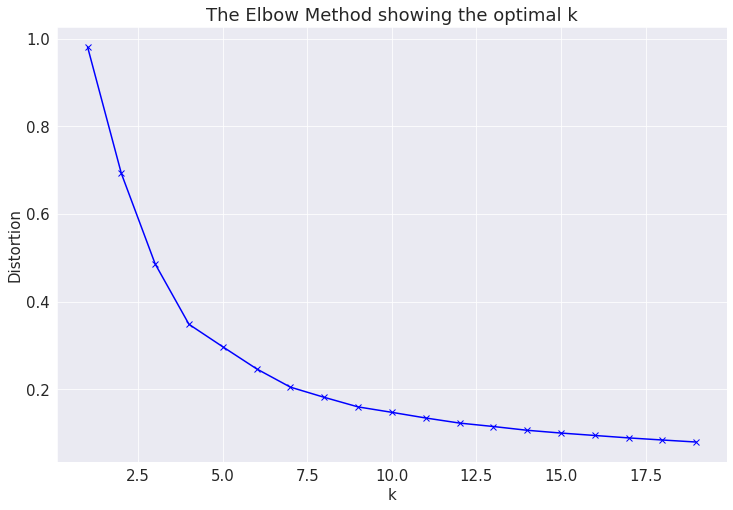

In [ ]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(kmX_pca)
    kmeanModel.fit(kmX_pca)
    distortions.append(sum(np.min(cdist(kmX_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / kmX_pca.shape[0])

# Plot the elbow
fig,ax = plt.subplots(figsize=(12,8))
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**K-means Analysis**

It is standard practice to standardize data and run PCA on the data set in order for k-means to function properly since, k-means concept is similar to knn in terms of distances and creating data points that aren't skewed by standarding them first. However, k-means have centroids where these data points will go to and form a cluster that will tell the user about what characteristics these clusters share.

I chose n_init as 20 in order to try different centroid seeds in order to obtain the best output in terms of minimizing distortion or the sum of squared errors for each cluster (i.e., cost function).

In [ ]:
# Turn the clusters into a data frame so that I can put it back
# in the data set. 
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']
df_y.head()

,Cluster
0,1
1,4
2,1
3,1
4,2


In [ ]:
# Attach clusters to the data frame.
clustered_x = X.join(df_y, how='inner')

clustered_x.head()

,device_id,gender,age,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,...,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,Cluster
6,8761770737926125955,0,22,4287147352639325907,0,226,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
98,-3775758989316758693,1,30,4287147352639325907,0,848,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
168,-1096491735238022299,0,24,4287147352639325907,0,371,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
188,-8042027671700398123,1,32,4287147352639325907,1,713,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
210,2671643523996911494,1,35,4287147352639325907,0,673,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create age method.

def age_bucket(age):
    output = ''
    if age <=20:
        output = 'Under 20'
    elif (age > 20 and age <= 30):
        output = 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        output = 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        output = 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        output = 'Between 50 and 60'
    else:
        output = 'Over 60'
    
    return output

In [ ]:

# Apply the method I just wrote. 
clustered_x['Age Bucket'] = clustered_x['age'].apply(lambda x: age_bucket(x))

Distribution of Age in Clusters


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


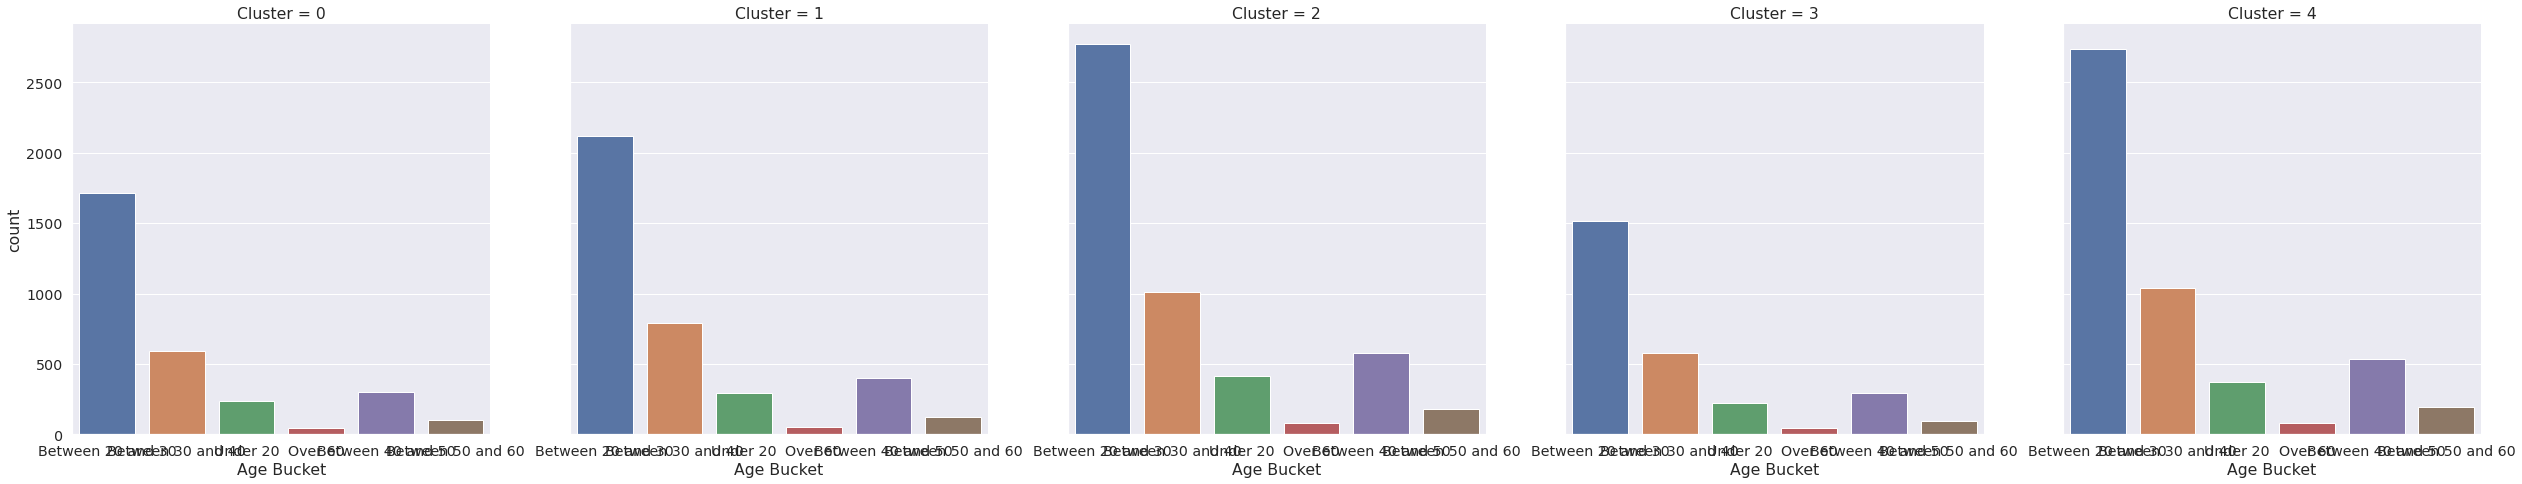

In [ ]:

# Look at Age Breakdown for Count
print('Distribution of Age in Clusters')
sns.set(font_scale=1.3)
sns.factorplot(x='Age Bucket', col='Cluster', kind="count", data=clustered_x, size=7)
plt.show()

Distribution of Gender in Clusters:
0=females, 1=males


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


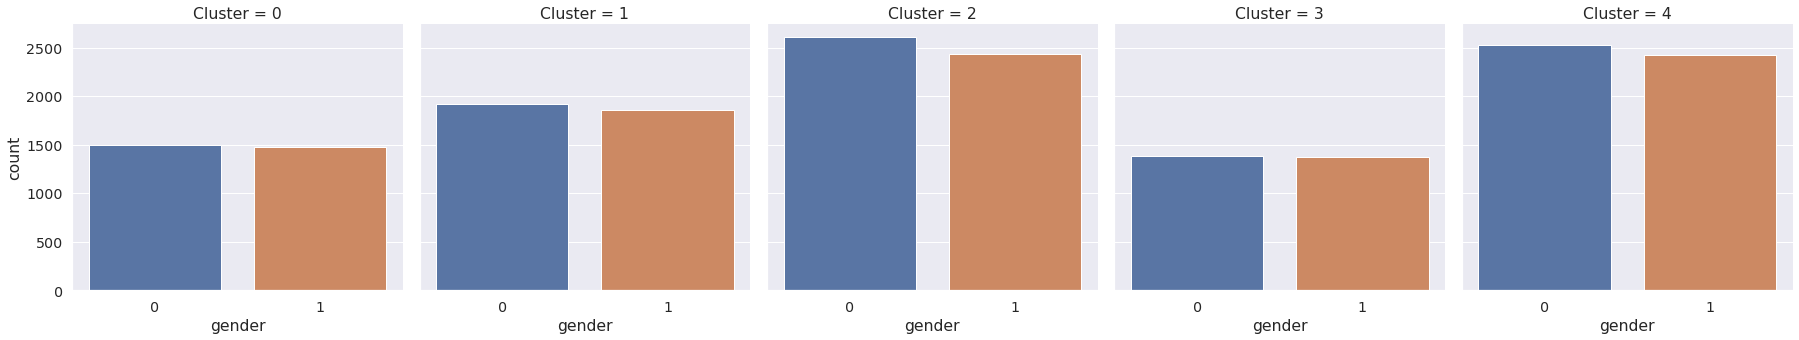

In [ ]:

# Take a look at gender
print('Distribution of Gender in Clusters:')
print('0=females, 1=males')
sns.factorplot(x='gender', col='Cluster', kind="count", data=clustered_x, size=5)
plt.show()

Distribution of Clusters on whether User is Active or Not:
0=inactive, 1=active


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


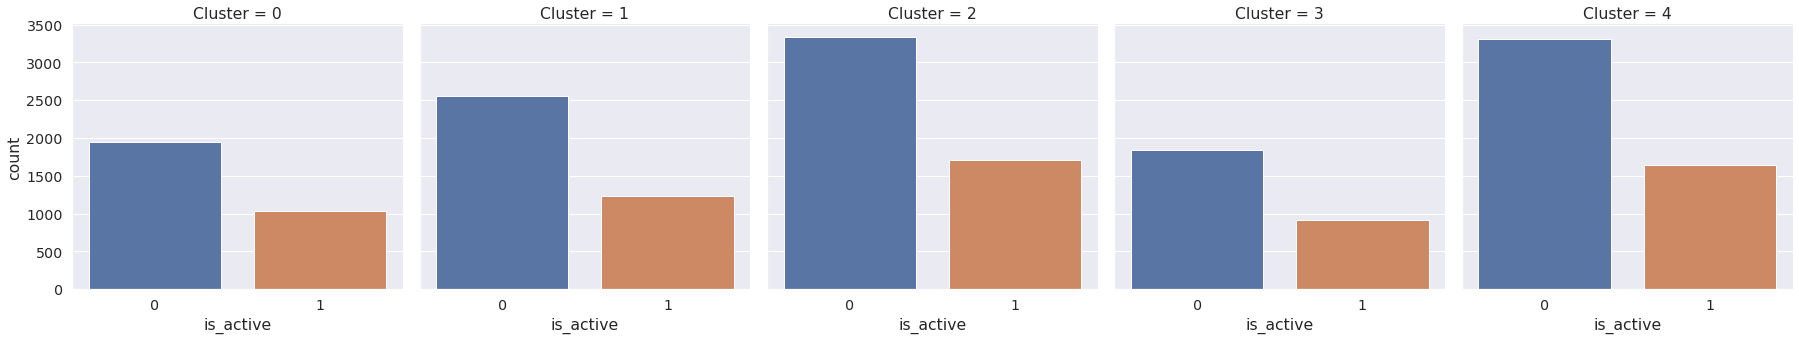

In [ ]:
# Take a look at is_active
print('Distribution of Clusters on whether User is Active or Not:')
print('0=inactive, 1=active')
sns.factorplot(x='is_active', col='Cluster', kind="count", data=clustered_x, size=5)
plt.show()

Analysis

Initial results showed that the optimal amount of clusters was 5.

In terms of age range, state of activity, and gender distribution, the 5 clusters are relatively equally distributed.

**Conclusion**


In an effort to find the best way to identify a customer's age range and gender given these particular parameters, I've come up with several different model's to see which model would most accurately identify a user's age range and gender. Of course, there was some tuning involved in each of these models, but some models required more tuning than other models, but in the end, I had four exceptionally strong models and one that performed reasonably well.

Better performing models were the logistic regression, random forest, X gradient boosted model which is another type of gradient boosting. The XGB model suffered from overfitting, it was so extreme some penalizations had to be instilled in order to achieve success. Furthermore, I also tried PCA on all three of those models which yielded good results, but I think random forest may not need PCA or SelectKBest in order to perform well.

Tried running a logistic regression model and KNN model on this project, but the accuracy of KNN wasn't that great. In the beginning, the logistic regression model did not perform well either, but after the usage of PCA, the logistic regression model became a strong performer too.

For ANN and CNN models, I found that no matter how we tune the parameters, the results would not be very good until the PCA version is used on the data set. Afterwards both models were able to obtain great results. 

Regarding Unsupervised algorithms,  I used k-means to see if I could correctly cluster the different groups but the results were quite modest.

In my opinion, even though XGB performed extremely well, it was too prone for overfitting which I had to control for, so the random forest model was the best model in terms of effectively recognizing the age range and gender given this data set. However, there are things to take note of, such as how the random forest is a black box model, but it's an extra step to see the course of the decision tree.

Lastly, this project is doable on a household computer, but it took a long time to run a few models, and the logistic regression model in particular crashed quite a few time, thus I purchased additonal RAM and set the Run time acclearator to TPU to make it work. Even after all those it was failing quite often, and I had to fine tune multiple times to get the results. 

Using PCA is also worth taking note of since it helps create entirely new independent features that explained the majority of the data set, but it also has a problem same as random forest in that I'm not sure what the principal components are comprised of out of the original features it used. Having said that, I'd still recommend using a random forest classifier in order to classify the group data because it required the least amount of tuning and it was relatively quick too.

**MODEL STATISTICS SUMMARY:**

Supervised Models:

      Logistic Regression with PCA       --> 0.99
      KNN Model                          --> .39114
      Random Forcest with/without 
        feature selection analysis      --> 0.9285
      Random forest with PCA            --> 0.91
      Feature-less Analysis             --> 0.56202
      X-Gradient Boosting with PCA      --> 0.9678

Deep Learning Models:

     ANN        --> 0.98
     CNN        --> 0.87
            
**NEXT STEPS & CHALLENGES:**

In order to make it work in a production like environment, we should set up the script in a server based (cloud or physical) environment and do some modifications in order to capture the new incoming data. This way with new incoming data we could predict new customer's gender and analyze if latter efforts, prior to our initial modelling, impact in real time to our potential or permanent customers. In addition, more computer power would be a plus to analyze the entire dataset.